In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = l2_regularizer))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tcumi\github_repo\neural-network\python\ga.py:200: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8148148148148148, Loss: 0.7213686483877676
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.7028483638057003
Checkpoint 300, Accuracy: 0.8148148148148148, Loss: 0.7017593383789062
Checkpoint 400, Accuracy: 0.8148148148148148, Loss: 0.706199222140842
Checkpoint 500, Accuracy: 0.8209876543209876, Loss: 0.7061927230269821


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [[0.28181863]
 [0.37293896]
 [0.34524238]]
[0. 0. 1.] <-> [[0.6866021 ]
 [0.17347418]
 [0.13992372]]
[1. 0. 0.] <-> [[0.7906712 ]
 [0.11804238]
 [0.09128641]]
[1. 0. 0.] <-> [[0.48875478]
 [0.27485138]
 [0.23639376]]
[1. 0. 0.] <-> [[0.9251197 ]
 [0.04406617]
 [0.03081415]]
[1. 0. 0.] <-> [[0.9174119 ]
 [0.0483921 ]
 [0.03419609]]
[1. 0. 0.] <-> [[0.83089286]
 [0.09622077]
 [0.07288637]]
[0. 1. 0.] <-> [[0.90831137]
 [0.05348665]
 [0.03820197]]
[1. 0. 0.] <-> [[0.6807687 ]
 [0.17653944]
 [0.14269188]]
[1. 0. 0.] <-> [[0.683343  ]
 [0.17518725]
 [0.14146975]]
[0. 1. 0.] <-> [[0.20637682]
 [0.4041261 ]
 [0.38949707]]
[1. 0. 0.] <-> [[0.39817378]
 [0.31915194]
 [0.28267428]]
[1. 0. 0.] <-> [[0.9332153 ]
 [0.03951569]
 [0.02726893]]
[1. 0. 0.] <-> [[0.36624378]
 [0.33433616]
 [0.29942006]]
[1. 0. 0.] <-> [[0.69457865]
 [0.16927566]
 [0.13614573]]
[1. 0. 0.] <-> [[0.8886435 ]
 [0.06444407]
 [0.04691253]]
[0. 0. 1.] <-> [[0.9106135 ]
 [0.05219933]
 [0.03718719]]
[0. 0. 1.] <->

In [11]:
# Testing Performance

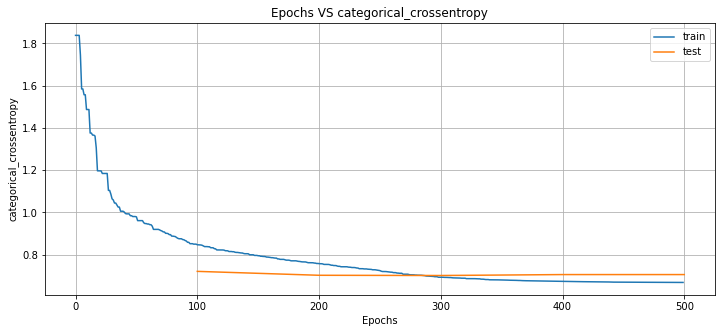

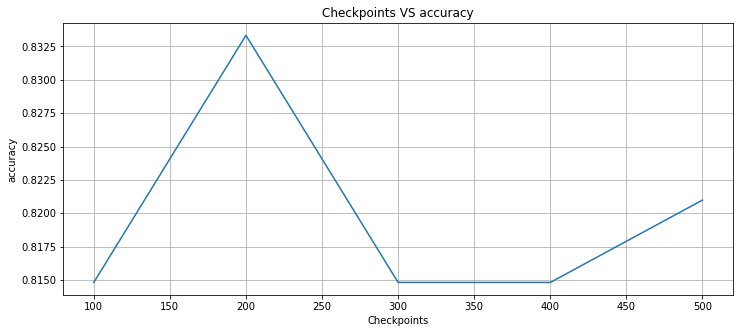

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8148148148148148, 'mean_square_error': 2.7196837413990047, 'categorical_crossentropy': 0.7213686483877676, 'precision': 0.7222222222222222, 'recall': 0.7222222222222222, 'f1': 0.7222222222222222, 'essential_metrics': {0: {'tp_hit': 68, 'fp_hit': 14, 'tn_hit': 18, 'fn_hit': 8}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 17}, 2: {'tp_hit': 10, 'fp_hit': 16, 'tn_hit': 77, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.795277372143827, 'categorical_crossentropy': 0.7028483638057003, 'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 5}, 1: {'tp_hit': 2, 'fp_hit': 6, 'tn_hit': 85, 'fn_hit': 15}, 2: {'tp_hit': 8, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 7}}, 'checkpoint': 200} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 2.779437825816135, 'categorical_crossentropy': 0.7017593383789062, 'precision': 0.7222222222222222, 'recall': 0.722222222

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[0.18953423]
 [0.17240475]
 [0.10000379]
 [0.1746081 ]
 [0.24025373]]
 bias: [-0.12279955]

Neuron 1: weights:
[[-0.28117314]
 [-0.2814921 ]
 [-0.31320554]
 [-0.2494518 ]
 [-0.2949259 ]]
 bias: [0.161942]

Neuron 2: weights:
[[0.17948574]
 [0.17050855]
 [0.15112619]
 [0.16431718]
 [0.29400772]]
 bias: [-0.12584849]

Neuron 3: weights:
[[-0.35243592]
 [-0.27258405]
 [-0.23706488]
 [-0.3335997 ]
 [-0.33451623]]
 bias: [0.21828769]

$
Layer 2
Neuron 0: weights:
[[-0.5454243 ]
 [ 0.92173946]
 [-0.45979914]
 [ 1.0289298 ]]
 bias: [0.42815617]

Neuron 1: weights:
[[ 0.14191948]
 [-0.5053126 ]
 [ 0.10403852]
 [-0.45033035]]
 bias: [0.02502153]

Neuron 2: weights:
[[ 0.30673838]
 [-0.47423756]
 [ 0.17980787]
 [-0.62014973]]
 bias: [-0.22795649]

$

